# Installation with pip
Every dependency needed by the framework will be downloaded and installed automatically

In [2]:
!pip install clayrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 225 kB 31.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 750.6 MB 21 kB/s 
     |████████████████████████████████| 6.2 MB 54.9 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 269 kB 72.9 MB/s 
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
     |████████████████████████████████| 26.9 MB 101.1 MB/s 
     |████████████████████████████████| 80 kB 12.2 MB/s 
     |████████████████████████████████| 31.6 MB 1.2 MB/s 
     |████████████████████████████████| 23.5 MB 89.8 MB/s 
     |████████████████████████████████| 83 kB 3.1 MB/s 
     |████████████████████████████████| 3.4 MB 68.8 MB/s 
     |████████████████████████████████| 9.7 MB 74.5 MB/s 
     |█████████████████

# **! RESTART RUNTIME !**

In [1]:
# for reproducibility but it's not perfect:
# some environment variables should be set before starting
# the python interpreter

import numpy
import random
numpy.random.seed(42)
random.seed(42)

# Correct order log and prints for IPython
This is necessary only for IPython environments (Colab, Jupyter, etc.), since they mess up the order of  ```print``` and ```logging```

```python
# EXAMPLE of the issue
import logging
print("Should go first")
logging.warning("Should go second")

WARNING:root:Should go second
Should go first
```

In [2]:
import functools
print = functools.partial(print, flush=True)

# Import and datasets download

The framework is made of three modules:
> 1.   Content Analyzer
> 2.   Recommender System
> 3.   Evaluation

We import every module as a library and use classes and methods by using the dot notation:

In [3]:
from clayrs import content_analyzer as ca
from clayrs import recsys as rs
from clayrs import evaluation as eva

# Usage:
# ...
# ca.Ratings()
# rs.ContentBasedRS()
# eva.EvalModel()
# ...

We use **Movielens 100k** as dataset, with items info expanded thanks to imdb

***POSSIBLE TO DO***: custom class with several built-in toy datasets?

In [4]:
import requests

def dl_file(url, output):
    r = requests.get(url, allow_redirects=True)
    with open(output, "wb") as handler:
        handler.write(r.content)

    print(f"Downloaded {output}!")

# Dataset: Movielens-100k

# download items_info
url_items_info = "https://raw.githubusercontent.com/swapUniba/clayrs/master/datasets/ml-100k/items_info.json"
dl_file(url_items_info, "items_info.json")

# download users_info
url_users_info = "https://raw.githubusercontent.com/swapUniba/clayrs/master/datasets/ml-100k/users_info.csv"
dl_file(url_users_info, "users_info.csv")

# download ratings
url_ratings = "https://raw.githubusercontent.com/swapUniba/clayrs/master/datasets/ml-100k/ratings.csv"
dl_file(url_ratings, "ratings.csv")

Downloaded items_info.json!
Downloaded users_info.csv!
Downloaded ratings.csv!


### Check items file
In this example, the file containing items info is a JSON where every entry corresponds to a movie.

For every movie there are various information, such as *genres, directors, cast, etc.*

In [5]:
with open("items_info.json", "r") as f:
  # 25 lines but in these 25 lines there are only 2 entries:
  # 'Toy Story', and 'Golden Eye'
  for _ in range(25):
    print(f.readline(), end='')


[
    {
        "movielens_id": "1",
        "imdb_id": "0114709",
        "title": "Toy Story",
        "plot": "A cowboy doll is profoundly threatened and jealous when a new spaceman figure supplants him as top toy in a boy's room.",
        "genres": "Animation, Adventure, Comedy, Family, Fantasy",
        "year": "1995",
        "rating": "8.3",
        "directors": "John Lasseter",
        "cast": "Tom Hanks, Tim Allen, Don Rickles, Jim Varney, Wallace Shawn, John Ratzenberger, Annie Potts, John Morris, Erik von Detten, Laurie Metcalf, R. Lee Ermey, Sarah Rayne, Penn Jillette, Jack Angel, Spencer Aste, Greg Berg, Lisa Bradley, Kendall Cunningham, Debi Derryberry, Cody Dorkin, Bill Farmer, Craig Good, Gregory Grudt, Danielle Judovits, Sam Lasseter, Brittany Levenbrown, Sherry Lynn, Scott McAfee, Mickie McGowan, Ryan O'Donohue, Jeff Pidgeon, Patrick Pinney, Phil Proctor, Jan Rabson, Joe Ranft, Andrew Stanton, Shane Sweet, Wayne Allwine, Tony Anselmo, Jonathan Benair, Anthony Burch, 

### Check users file
In this example, the file containing users info is a CSV file where the first column is the *user id*, while the other columns are side information for that user (*gender, occupation, zip code*)

In [6]:
with open("users_info.csv", "r") as f:

  # print the header and the first 2 entries
  for _ in range(3):
    print(f.readline(), end='')

user_id,age,gender,occupation,zip_code
1,24,M,technician,85711
2,53,F,other,94043


<a name="cell-id"></a>
### Check ratings
In this example, the file containing the interactions between the users and the movies is a CSV, where every interaction is a rating in the **[1, 5]** Likert scale

In [7]:
import pandas as pd

pd.read_csv('ratings.csv')

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


# Content Analyzer: representation of Items
In order to define the *item representation*, the following parameters should be defined:
*   ***source***: the path of the file containing items info
*   ***id***: the field that uniquely identifies an item
*   ***output_directory***: the path where serialized representations are saved



In [8]:
# Configuration of item representation 
movies_ca_config = ca.ItemAnalyzerConfig(
    source=ca.JSONFile('items_info.json'),
    id='movielens_id',
    output_directory='movies_codified/',
)

<a name="ca_id"></a>
Each item can be represented using a set of fields.
Every field can be **represented** using several techniques, such as *'tfidf'*, *'entity linking'*, *'embeddings'*, etc.

It is possible to process the content of each field using a **Natural Language Processing (NLP) pipeline**. 

> In the following example, we **expand** every item by retrieving its properties from **DBPedia**


In order to do that, we call the `add_single_exogenous()` method *(or `add_multiple_exogenous()` in case of multiple exogenous techniques)* and pass the DBPediaMappingTechnique object:

*   The **first parameter** is the entity type of every content (*dbo:Film* in this case). Multiple prefixes such as `rdf`, `rdfs`, `foaf`, `dbo` are imported by default, but if you need another type of entity you can pass its uri directly\
`
'dbo:Film' <-EQUIVALENT-> '<http://dbpedia.org/ontology/Film>'
`
*   The **second parameter** is the field in the raw source which must exactly match the string representation of the *rdfs:label* of the content on DBPedia

In [9]:
movies_ca_config.add_single_exogenous(
    ca.ExogenousConfig(ca.DBPediaMappingTechnique('dbo:Film', 'dbpedia_label', max_timeout=8),
                       id='dbpedia')
)

# in case max retries is reached multiple times

# movies_ca_config.add_single_exogenous(
#     ca.ExogenousConfig(ca.PropertiesFromDataset(field_name_list=["directors", "year",
#                                                                  "rating", "genres"]),
#                        id='local')
# )

At the end of the configuration step, we provide the configuration to the *'Content Analyzer'* and call the `fit()` method:

*   The Content Analyzer will **represent** and **serialize** every item.



In [10]:
# About ~6min are required to query 1682 
ca.ContentAnalyzer(config=movies_ca_config).fit()

INFO - Extracting exogenous properties from DBPedia
INFO - Contents mapped so far: 612 of 1682 (ideal, tipically less are mapped)
INFO - Contents mapped so far: 741 of 1682 (ideal, tipically less are mapped)
INFO - Contents mapped so far: 910 of 1682 (ideal, tipically less are mapped)
WARNING - Timeout occurred! - 1 out of 8 possible 
The timeout counter will be reset as soon as the request goes through
WARNING - Timeout occurred! - 2 out of 8 possible 
The timeout counter will be reset as soon as the request goes through
WARNING - Timeout occurred! - 3 out of 8 possible 
The timeout counter will be reset as soon as the request goes through
WARNING - Timeout occurred! - 4 out of 8 possible 
The timeout counter will be reset as soon as the request goes through
INFO - Contents mapped so far: 1058 of 1682 (ideal, tipically less are mapped)
WARNING - Timeout occurred! - 1 out of 8 possible 
The timeout counter will be reset as soon as the request goes through
INFO - Contents mapped so far:

# Content Analyzer: representation of Users
In order to define the *'user representation'*, we could use the same process performed for *'item representation'*.

In this example, the ID for users is the column `user_id`.

In [11]:
# Configuration of user representation
users_ca_config = ca.UserAnalyzerConfig(
    ca.CSVFile('users_info.csv'),
    id='user_id',
    output_directory='users_codified/',
)

Also users can be represented with additional exogenous information.

`PropertiesFromDataset()` object allows to specify which fields to use in order to expand every user info

*   If no field is specified, **all fields** from the raw source will be used

> In this case, we expand every user with *gender* and *occupation*

In [12]:
users_ca_config.add_single_exogenous(
    ca.ExogenousConfig(ca.PropertiesFromDataset(field_name_list=['gender', 'occupation']))
)

# Call the fit() method to create and serialize every user
ca.ContentAnalyzer(config=users_ca_config).fit()

INFO - Extracting exogenous properties from local dataset
Serializing contents:  100%|██████████| 943/943 [00:01<00:00]


# Recommender System: Pagerank 

The Recommender System module needs information about users, items and ratings. 

The **Ratings** class allows you to import rating from a source file (or also from an existent dataframe) into a custom object.   **If** the source file contains users (U), items (I) and ratings (R) in this order, no additional parameters are needed, **otherwise**  the mapping must be explictly specified using:

*   **'user_id'** column,
*   **'item_id'** column,
*   **'score'** column





In [13]:
ratings = ca.Ratings(ca.CSVFile('ratings.csv'))

print(ratings)

Importing ratings:  100%|██████████| 100000/100000 [00:00<00:00]


      user_id item_id  score
0         196     242    3.0
1         196     393    4.0
2         196     381    4.0
3         196     251    3.0
4         196     655    5.0
...       ...     ...    ...
99995     941     919    5.0
99996     941     273    3.0
99997     941       1    5.0
99998     941     294    4.0
99999     941    1007    4.0

[100000 rows x 3 columns]


In [14]:
# (mapping by index) EQUIVALENT:
#
# ratings = ca.Ratings(
#     ca.CSVFile('ratings.csv'),
#     user_id_column=0,
#     item_id_column=1,
#     score_column=2
# )
#
# print(ratings)

In [15]:
# (mapping by column name) EQUIVALENT:

# ratings = ca.Ratings(
#     ca.CSVFile('ratings.csv'),
#     user_id_column='user_id',
#     item_id_column='item_id',
#     score_column='rating'
# )
#
# print(ratings)

Ratings imported are used to create a **Full Graph** where property nodes (e.g. *gender* for users, *budget* for movies) can be linked to every node without any restriction

> The framework also allows to create a **Bipartite Graph** (a graph without property node) and a **Tripartite Graph** (where property nodes are only linked to item nodes)

In order to load properties in the graph, we must specify where users and items are serialized and ***which properties to add*** (the following is the same for *item_exo_properties*):

*   If *user_exo_properties* is specified as a **set**, then the graph will try to load **all properties** from **said exogenous representation**
```python
# example
{'my_exo_id'}
```

*   If *user_exo_properties* is specified as a **dict**, then the graph will try to load **said properties** from **said exogenous representation**
```python
# example
{'my_exo_id': ['my_prop1', 'my_prop2']]}
```

Let's now create the graph loading all properties from the exogenous representations we created earlier:

In [16]:
full_graph = rs.NXFullGraph(ratings, 
                            user_contents_dir='users_codified/',
                            item_contents_dir='movies_codified/',
                            user_exo_properties={0},  # Since no custom id given
                            item_exo_properties={0},  # equivalent 'dbpedia' (or 'local')
                            link_label='score')

Creating User->Item links:  100%|██████████| 100000/100000 [00:01<00:00]
INFO - Loading contents from disk...
Creating Node->Properties links:  100%|██████████| 1682/1682 [00:00<00:00]
INFO - Loading contents from disk...
Creating Node->Properties links:  100%|██████████| 943/943 [00:00<00:00]


The underlying implementation of graphs in the framework uses the **networkx** library: so let's use its methods to draw a subgraph, just to make sure the graph has been created


> We draw the *interaction* between **user 308** and **Item 1** (Toy Story), as well as the *occupation* and *gender* properties of the user and the *runtime* property of the item



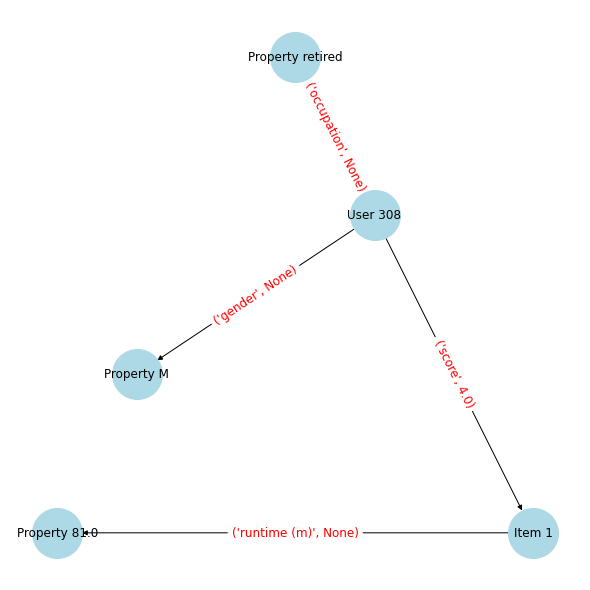

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# convert graph to networkx
networkx_graph = full_graph.to_networkx()

plt.figure(3,figsize=(8,8)) 
H = nx.subgraph(networkx_graph, [rs.ItemNode("1"), rs.PropertyNode("81.0"),
                                 rs.UserNode("308"), rs.PropertyNode("retired"),
                                 rs.PropertyNode("M")])

# use this if you didn't extract props from dbpedia
#
# H = nx.subgraph(networkx_graph, [rs.ItemNode("1"), rs.PropertyNode("John Lasseter"),
#                                  rs.UserNode("308"), rs.PropertyNode("retired"),
#                                  rs.PropertyNode("M")])

pos = nx.planar_layout(H)

nx.draw(H, with_labels=True, font_weight='light', node_color='lightblue', node_size=2500, pos=pos)

edge_labels = dict([((n1, n2), (d['label'], d.get('weight')))
                    for n1, n2, d in H.edges(data=True)])

nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels,
                             font_color='red', font_size=12, font_weight='normal')

plt.show()

As you can see each link between nodes has two *attributes* wrapped in a tuple:
* The first element is the ***label*** of the link
* The second element is the ***weight*** of the link

In our case only links between users and items have a weight associated to them
* This behaviour can be easily modified when adding new links

The Recommender System also needs an algorithm for ranking or predicting items to users. In the following example we use the **PageRank** algorithm.


In [19]:
pr = rs.NXPageRank()

Before we can instantiate the recommender system, we should split the original dataset. So let's perform the **HoldOut** method:
*   The output of the partition module are two lists. One containing one train set (in this case), the other containing one test set (in this case)

In [20]:
# by default train_set_size = 0.8
[train_set], [test_set] = rs.HoldOutPartitioning(random_state=24).split_all(ratings)

Performing HoldOutPartitioning:  100%|██████████| 943/943 [00:00<00:00]


Then, in order to not influence the recommendation process, we remove from the graph each link (interaction) that appears in the test set

* We do not build the graph directly from the train set because otherwise we can't recommend items that appear in the test set but do not appear in the train set!

In [21]:
for interaction in test_set:

    user_node = rs.UserNode(interaction.user_id)
    item_node = rs.ItemNode(interaction.item_id)

    full_graph.remove_link(user_node, item_node)

The Graph Based Recommender System only needs the recommendation algorithm and the graph. No contents directory is required.

In [22]:
gbrs = rs.GraphBasedRS(pr, full_graph)

It is possible to provide recommendations as a ranked list for a single user:

In [23]:
rank = gbrs.rank(test_set, user_id_list=['3'], n_recs=3)

print(rank)

Computing rank for user 3:  100%|██████████| 1/1 [00:00<00:00]

  user_id item_id     score
0       3     300  0.000561
1       3     181  0.000498
2       3     328  0.000411


It is also possible to provide recommendations for a list of users:

In [24]:
multiple_rank = gbrs.rank(test_set, user_id_list=['8', '2', '1'], n_recs=3)

print(multiple_rank)

Computing rank for user 8:  100%|██████████| 3/3 [00:00<00:00]

  user_id item_id     score
0       1      50  0.000669
1       1     269  0.000516
2       1     181  0.000498
3       2      50  0.000669
4       2       1  0.000466
5       2     237  0.000384
6       8     258  0.000695
7       8     172  0.000320
8       8      79  0.000266


Let's compute now recommendations for all users of the test set:

In [25]:
gbrs = rs.GraphBasedRS(pr, full_graph)

# n_recs=None will return rank score for all unrated items for each
# user (depending on the specific methodology)
rank = gbrs.rank(test_set, n_recs=None)

Computing rank for user 312:  100%|██████████| 943/943 [00:17<00:00]


# Evaluation module

Recommendations can be evaluated using several metrics. In the following example, we use:

*   ***RPrecision***
*   ***MRR***
*   ***Gini Index***
*   ***Long Tail Distribution***
*   ***Prediction coverage***

The Evaluation module needs the following parameters:

*   A list of computed rank/predictions (in case multiple splits must be evaluated)
*   A list of truths (in case multiple splits must be evaluated)
*   List of metrics to compute

Obviously the list of computed rank/predictions and list of truths must have the same length, and the rank/prediction in position $i$ will be compared with the truth at position $i$

In [26]:
# we consider as the entire catalog every item that has
# been rated at least once by someone
catalog = set(ratings.item_id_column)

em = eva.EvalModel(
    [rank],
    [test_set],
    metric_list=[
        eva.RPrecision(),
        eva.MRR(),
        eva.GiniIndex(),
        eva.LongTailDistr(out_dir="guided_example"),
        eva.PredictionCoverage(catalog)
    ]
)

The fit() method returns two pandas DataFrame: the first one contains the metrics aggregated for the system, while the second contains the metrics computed for each user (where possible)

In [27]:
sys_result, users_result = em.fit()

INFO - Performing evaluation on metrics chosen
Performing PredictionCoverage:  100%|██████████| 5/5 [00:00<00:00]


In [28]:
sys_result

,R-Precision - macro,MRR,Gini,PredictionCoverage
user_id,,,,
sys - fold1,0.611958,0.798925,0.570866,83.71
sys - mean,0.611958,0.798925,0.570866,83.71


In [29]:
users_result

,R-Precision - macro
user_id,
1,0.696970
10,0.529412
100,0.600000
101,0.888889
102,0.653846
...,...
95,0.560000
96,0.400000
97,0.777778


The following chart is generated:

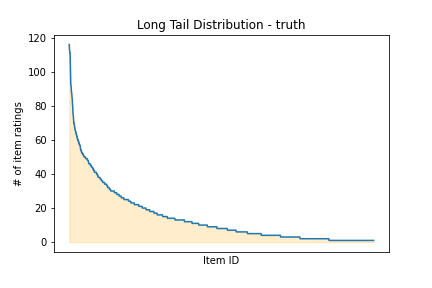

In [30]:
from IPython.display import Image
Image('guided_example/long_tail_distr_truth.png')

# Your turn !

Do not overwrite results of each answer and the results of the guided example!
* You may need them to answer some of the questions below :)

## PageRank with Train Items methodology

1. Compute recommendations with the Page Rank as shown above but using the ***train items methodology***
    * Do not limit the number of recommendations per user
2. Evaluate recommendations computed in point 1. with the following metrics:
    *   ***RPrecision***
    *   ***Gini index***
    *   ***DeltaGap***
    *   ***Prediction coverage***
    *   ***Profile vs Recommendations (Popularity comparison)***
    *   ***Correlation between Popularity and Recommendation Frequency***
3. Compare **RPrecision**, **Gini Index**, **Prediction Coverage** between results obtained in the point 2. and results obtained in the [guided example](#scrollTo=yIpALBnr4Azi) with the TestRatings methodology
    * What do we expect?


For the **DeltaGap** metric consider the following as user groups:

```python
user_groups = {'popular': 0.4, 'bb-diverse': 0.4, 'niche': 0.2}
```

**Info about methodologies:**

> For each target user $u$, the following 4 different methodologies are available for defining those lists:
> 1.   **TestRatings** (default): the list of items to be evaluated consists of items rated by $u$ in the test set
> 2.   **TestItems**: every item in the test set of every user except those in the training set of the target user will be predicted
> 3.   **TrainingItems**: every item in the training set of every user will be predicted except those in the training set of the target user
> 4.   **AllItems**: the whole set of items, except those in the training set of the target user, will be predicted
>
> More information on [this paper](https://repositorio.uam.es/bitstream/handle/10486/665121/precision-oriented_bellogin_recsys_2011_ps.pdf;jsessionid=85982302D4DA9FF4DD7F21E4AC4F3391?sequence=1).

### Answer to 1

### Answer to 2

### Answer to 3

## Personalized page rank

Compute recommendations with the ***Personalized Page Rank*** with weighting schema *60/20/20* using the *training items methodology* and compare the top-10 ranking for user **1** you obtain with the personalized page rank and the classical page rank of the [previous question](#scrollTo=a8NrtjarrYYw)

### Answer